# > Initial setting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# > Load data and preprocessing

## >> Soft Skills

In [2]:
df1 = pd.read_excel("datasets/skills.xlsx")

In [ ]:
# select relevant columns
skills = df1.copy()
skills = skills.iloc[:,  [1, 3, 5, 6, 12]]

# unpivot the element name to have two columns
skills = skills.pivot_table(
    index=["Title", "Element Name"],
    columns="Scale Name",
    values="Data Value"
).reset_index()

# merge not relevant back to the main dataframe
nr = df1[df1['Scale Name']=='Level'][['Title','Element Name','Not Relevant']]
skills = skills.merge(nr, on=['Title','Element Name'], how='left')

# add column for soft_skills, average between importance and level
skills['soft_skills'] = skills[['Importance', 'Level']].mean(axis=1)

# filter to only relevant skills
skills = skills[skills['Not Relevant'] != "Y"]

skills.head()

,Title,Element Name,Importance,Level,Not Relevant,soft_skills
0,Accountants and Auditors,Active Learning,3.12,3.50,N,3.310
1,Accountants and Auditors,Active Listening,3.75,3.88,N,3.815
2,Accountants and Auditors,Complex Problem Solving,3.38,3.50,N,3.440
3,Accountants and Auditors,Coordination,3.25,3.25,N,3.250
4,Accountants and Auditors,Critical Thinking,3.75,4.12,N,3.935


In [4]:
# aggregate for each Title
skills = skills.groupby('Title')['soft_skills'].mean().reset_index()
print(skills.head())

print(f"Total job roles: {skills.shape[0]}")

                      Title  soft_skills
0  Accountants and Auditors     2.920179
1                    Actors     2.721818
2                 Actuaries     3.247759
3            Acupuncturists     2.506613
4         Acute Care Nurses     3.183125
Total job roles: 894


## >> Tech Skills

In [5]:
df2 = pd.read_excel("datasets/tech_skills.xlsx")

In [6]:
# select relevant columns
tech = df2.copy()
tech = tech.iloc[:,  [1, 2, 4, 5, 6]]
tech.head()


,Title,Example,Commodity Title,Hot Technology,In Demand
0,Chief Executives,Adobe Acrobat,Document management software,Y,N
1,Chief Executives,AdSense Tracker,Data base user interface and query software,N,N
2,Chief Executives,Atlassian JIRA,Content workflow software,Y,N
3,Chief Executives,Blackbaud The Raiser's Edge,Customer relationship management CRM software,N,N
4,Chief Executives,ComputerEase construction accounting software,Accounting software,N,N


In [7]:
# convert Y to 1 and N to 0
tech["Hot Technology"] = tech["Hot Technology"].map({"Y": 1, "N": 0})
tech["In Demand"] = tech["In Demand"].map({"Y": 1, "N": 0})

# aggregate for each Title
tech = (
    tech.groupby("Title")
    .agg(
        hot_tech=("Hot Technology", "sum"),
        in_demand=("In Demand", "sum")
    )
    .reset_index()
)

# create tech skills score by divide in_demand by hot_tech
tech["tech_raw"] = tech["in_demand"] / tech["hot_tech"]

# min-max scale to 1–5 range
min_val = tech["tech_raw"].min()
max_val = tech["tech_raw"].max()

tech["tech_skills"] = 1 + 4 * (tech["tech_raw"] - min_val) / (max_val - min_val)
print(tech.head())
print(f"Total job roles: {tech.shape[0]}")

                      Title  hot_tech  in_demand  tech_raw  tech_skills
0  Accountants and Auditors        37          7  0.189189     1.756757
1                    Actors         9          0  0.000000     1.000000
2                 Actuaries        20         10  0.500000     3.000000
3            Acupuncturists         5          0  0.000000     1.000000
4         Acute Care Nurses         9          0  0.000000     1.000000
Total job roles: 923


In [8]:
# summary of tech skills
tech['tech_skills'].describe()

count    904.000000
mean       1.700465
std        0.866563
min        1.000000
25%        1.000000
50%        1.400000
75%        2.182353
max        5.000000
Name: tech_skills, dtype: float64

## >> AI Labor Index

In [9]:
df3 = pd.read_excel("datasets/ali.xlsx")

In [10]:
ali = df3.copy()
ali = ali.iloc[:,  [0, 1, 4, 6, 3]]
ali.head()

,task,suboccupation,llm_ai,software,automation
0,"Bill customers for repair work, and collect pa...",Home Appliance Repairers,0,5,5
1,Compare instrument pitches with tuning tool pi...,Musical Instrument Repairers and Tuners,0,5,5
2,Order parts needed for machine repairs.,"Coin, Vending, and Amusement Machine Servicers...",0,5,5
3,Maintain records of machine maintenance and re...,"Coin, Vending, and Amusement Machine Servicers...",2,5,5
4,Keep records of employees' attendance and hour...,First-Line Supervisors of Production and Opera...,0,5,5


In [11]:
# aggregate by suboccupation with average of llm_ai, software, and automation columns
ali = (
    ali.groupby("suboccupation")
    .agg(
        llm_ai=("llm_ai", "mean"),
        software=("software", "mean"),
        automation=("automation", "mean")
    )
    .reset_index()
)
print(ali.head())
print(f"Total job roles: {ali.shape[0]}")

              suboccupation    llm_ai  software  automation
0  Accountants and Auditors  2.965517  3.758621    3.344828
1                    Actors  1.722222  0.888889    1.722222
2                 Actuaries  2.666667  2.866667    2.800000
3            Acupuncturists  2.000000  2.111111    2.611111
4         Acute Care Nurses  2.120000  1.920000    2.400000
Total job roles: 923


## >> Merge dataset

In [12]:
# merge between ali, skills, and tech_skills
df = skills
df = df.merge(tech, on="Title", how="inner")
df = df.merge(ali, left_on="Title", right_on="suboccupation", how="inner")
df.head()

,Title,soft_skills,hot_tech,in_demand,tech_raw,tech_skills,suboccupation,llm_ai,software,automation
0,Accountants and Auditors,2.920179,37,7,0.189189,1.756757,Accountants and Auditors,2.965517,3.758621,3.344828
1,Actors,2.721818,9,0,0.000000,1.000000,Actors,1.722222,0.888889,1.722222
2,Actuaries,3.247759,20,10,0.500000,3.000000,Actuaries,2.666667,2.866667,2.800000
3,Acupuncturists,2.506613,5,0,0.000000,1.000000,Acupuncturists,2.000000,2.111111,2.611111
4,Acute Care Nurses,3.183125,9,0,0.000000,1.000000,Acute Care Nurses,2.120000,1.920000,2.400000


In [13]:
print(f"Total job roles: {df.shape[0]}")

Total job roles: 894


In [14]:
# show NaN values
print(df.isna().sum())

Title             0
soft_skills       0
hot_tech          0
in_demand         0
tech_raw         19
tech_skills      19
suboccupation     0
llm_ai            0
software          0
automation        0
dtype: int64


In [15]:
# remove rows with NaN values
df = df.dropna()
print(df.isna().sum())

Title            0
soft_skills      0
hot_tech         0
in_demand        0
tech_raw         0
tech_skills      0
suboccupation    0
llm_ai           0
software         0
automation       0
dtype: int64


# > Regression

## >> Split

In [16]:
from sklearn.model_selection import train_test_split

# Define HR managers, as we want to see their automation prediction
hr_managers = [
    'Compensation and Benefits Managers',
    'Training and Development Managers',
    'Human Resources Managers'
]
test_df = df[df['Title'].isin(hr_managers)]
train_df = df[~df['Title'].isin(hr_managers)]

# Define target and features
y = df["automation"]
X = df.drop(columns=["hot_tech", "in_demand", "tech_raw", "Title"])

# Split the data
X_train_raw, X_temp, y_train, y_temp = train_test_split(
    train_df.drop(columns="automation"),
    train_df["automation"],
    test_size=0.3,
    random_state=15
)

# Concat
X_test_raw = pd.concat([X_temp, test_df.drop(columns="automation")])
y_test = pd.concat([y_temp, test_df["automation"]])

## >> Recipe

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

# Preprocessing steps
num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nzv', VarianceThreshold(threshold=1e-4))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, ['soft_skills', 'tech_skills', 'llm_ai', 'software'] )
], remainder='drop', verbose_feature_names_out=False)

# OLS Regression Pipeline
ols_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

# Ridge, Lasso, and Elastic Net Pipelines
ridge = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=10)
lasso = LassoCV(alphas=np.logspace(-3, 3, 50), cv=10, max_iter=5000)
elastic = ElasticNetCV(alphas=np.logspace(-3, 3, 50),
                       l1_ratio=[.1, .5, .9],
                       cv=10,
                       max_iter=5000)

ridge_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', ridge)
])

lasso_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', lasso)
])

elastic_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', elastic)
])

## >> OLS Regression

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

ols_pipe.fit(X_train_raw, y_train)
y_pred = ols_pipe.predict(X_test_raw)

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.4f}")

rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")

R-squared: 0.6128
Mean squared error: 0.0762
Root mean squared error: 0.2761


In [19]:
import statsmodels.api as sm
feature_names = ols_pipe.named_steps['preprocess'].get_feature_names_out()
X_baked = pd.DataFrame(
    ols_pipe.named_steps['preprocess'].transform(X_train_raw),
    columns=feature_names,
    index=X_train_raw.index
)
X_with_const = sm.add_constant(X_baked)

ols_model = sm.OLS(y_train, X_with_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             automation   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     277.0
Date:                Thu, 27 Nov 2025   Prob (F-statistic):          3.54e-135
Time:                        00:26:17   Log-Likelihood:                -68.420
No. Observations:                 610   AIC:                             146.8
Df Residuals:                     605   BIC:                             168.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.9736      0.011    270.198      

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Check for multicollinearity using VIF
vif_df = pd.DataFrame()
vif_df['feature'] = X_baked.columns
vif_df['VIF'] = [variance_inflation_factor(X_baked.values, i) for i in range(X_baked.shape[1])]
vif_df = vif_df.sort_values(by='VIF', ascending=False).reset_index(drop=True)
print(vif_df)

       feature       VIF
0       llm_ai  3.110926
1  soft_skills  2.087671
2     software  1.885541
3  tech_skills  1.277588


## >> Regularized Regression

In [21]:
models = {
    "OLS": ols_pipe,
    "Ridge": ridge_pipe,
    "Lasso": lasso_pipe,
    "ElasticNet": elastic_pipe
}

results = []

for name, pipe in models.items():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    
    train_r2 = pipe.score(X_train_raw, y_train)
    test_r2 = pipe.score(X_test_raw, y_test)
    mse = mean_squared_error(y_test, y_pred)
    
    reg = pipe.named_steps['regressor']
    alpha = getattr(reg, 'alpha_', np.nan)
    l1_ratio = getattr(reg, 'l1_ratio_', np.nan)
    
    results.append({
        "Model": name,
        "Alpha": alpha,
        "L1 Ratio": l1_ratio,
        "Train R²": train_r2,
        "Test R²": test_r2,
        "Test MSE": mse,
        "Δ Train-Test R²": train_r2 - test_r2
    })

comparison_df = pd.DataFrame(results).round(4)
print(comparison_df)


        Model   Alpha  L1 Ratio  Train R²  Test R²  Test MSE  Δ Train-Test R²
0         OLS     NaN       NaN    0.6469   0.6128    0.0762           0.0341
1       Ridge  6.2506       NaN    0.6465   0.6144    0.0759           0.0322
2       Lasso  0.0010       NaN    0.6468   0.6129    0.0762           0.0339
3  ElasticNet  0.0023       0.1    0.6468   0.6132    0.0762           0.0336


## >> Evaluation

In [22]:
# Count non-zero coefficients
non_zero_count = np.sum(lasso_pipe.named_steps['regressor'].coef_ != 0)

print("Non-zero coefficients:", non_zero_count)

Non-zero coefficients: 4


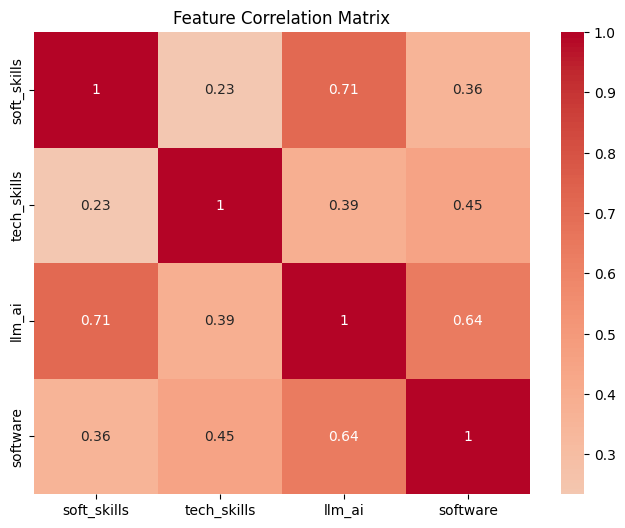

In [23]:
%matplotlib inline

# Plot correlation matrix
corr = X_baked.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

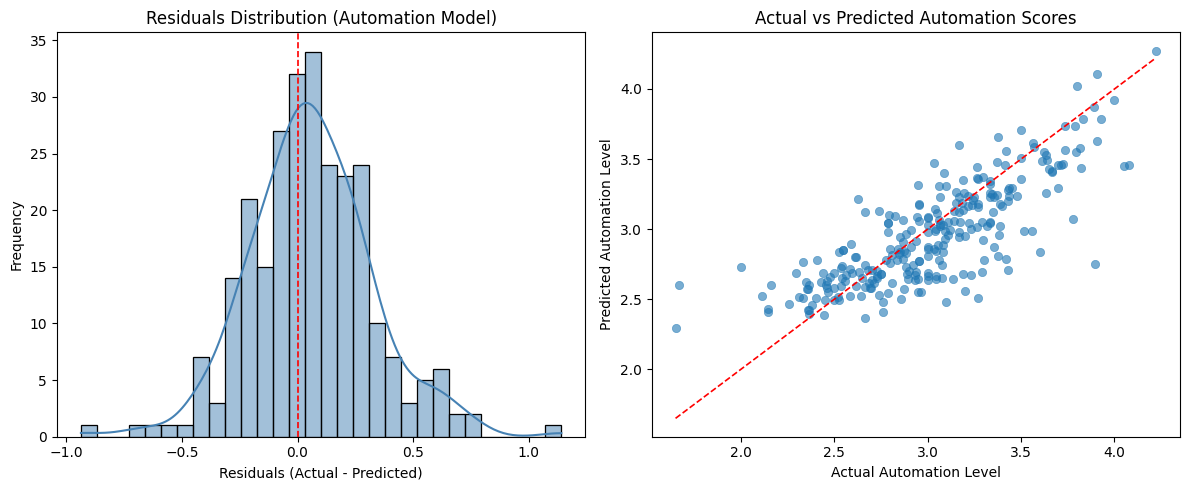

In [24]:
# Compute predictions based on the best model (Ridge)
best_model = ridge_pipe
y_pred = best_model.predict(X_test_raw)

# Compute residuals
residuals = y_test - y_pred

# Create plots
plt.figure(figsize=(12, 5))

# Plot 1: Residuals Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, bins=30, kde=True, color="steelblue")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.2)
plt.title("Residuals Distribution (Automation Model)")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")

# Plot 2: Actual vs Predicted Automation Scores
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=1.2)
plt.title("Actual vs Predicted Automation Scores")
plt.xlabel("Actual Automation Level")
plt.ylabel("Predicted Automation Level")

plt.tight_layout()
plt.show()

## >> Map predicted automation for HR managers

In [25]:
# Apply the same preprocessing as model used
X_baked_test = preprocessor.transform(X_test_raw)

# Manually rebuild column names
feature_names = preprocessor.get_feature_names_out()
X_baked_test = pd.DataFrame(X_baked_test, columns=feature_names, index=X_test_raw.index)

# Add automation columns
X_baked_test['automation_actual'] = y_test.values
X_baked_test['automation_predicted'] = y_pred

# Add metadata
meta_subset = df.loc[X_test_raw.index, ['suboccupation']].reset_index(drop=True)
global_roles = pd.concat([X_baked_test.reset_index(drop=True), meta_subset], axis=1)
display(global_roles.head())

,soft_skills,tech_skills,llm_ai,software,automation_actual,automation_predicted,suboccupation
0,0.726862,-0.355035,0.923674,0.093003,2.680000,2.710069,"Business Teachers, Postsecondary"
1,-0.252575,-0.303892,0.563492,0.857717,3.333333,3.229840,"Sales Representatives, Wholesale and Manufactu..."
2,-0.231071,-0.815315,-1.522112,-1.992578,2.760000,2.479288,Mechanical Door Repairers
3,1.661635,0.718953,0.283111,-1.054066,1.650000,2.292028,"Judges, Magistrate Judges, and Magistrates"
4,-1.657374,-0.815315,-1.755044,-0.248274,3.818182,3.436169,"Cleaning, Washing, and Metal Pickling Equipmen..."


### >>> Global roles

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Normalize automation scores
scaler = MinMaxScaler()
global_roles['automation_scaled'] = scaler.fit_transform(
    global_roles[['automation_predicted']]
)

# Add percentile ranking for automation
global_roles['rank_percentile'] = (
    global_roles['automation_scaled'].rank(pct=True, ascending=False) * 100
)

display(global_roles)

,soft_skills,tech_skills,llm_ai,software,automation_actual,automation_predicted,suboccupation,automation_scaled,rank_percentile
0,0.726862,-0.355035,0.923674,0.093003,2.680000,2.710069,"Business Teachers, Postsecondary",0.211021,67.924528
1,-0.252575,-0.303892,0.563492,0.857717,3.333333,3.229840,"Sales Representatives, Wholesale and Manufactu...",0.473394,24.150943
2,-0.231071,-0.815315,-1.522112,-1.992578,2.760000,2.479288,Mechanical Door Repairers,0.094526,95.849057
3,1.661635,0.718953,0.283111,-1.054066,1.650000,2.292028,"Judges, Magistrate Judges, and Magistrates",0.000000,100.000000
4,-1.657374,-0.815315,-1.755044,-0.248274,3.818182,3.436169,"Cleaning, Washing, and Metal Pickling Equipmen...",0.577545,12.830189
...,...,...,...,...,...,...,...,...,...
260,-2.852156,1.486087,-1.755044,-2.394798,3.428571,2.711826,Slaughterers and Meat Packers,0.211908,67.547170
261,-1.255288,-0.815315,-1.366824,-1.992578,3.200000,2.557279,Pile Driver Operators,0.133895,88.679245
262,1.080221,0.267698,0.980142,0.320522,2.954545,2.770852,Compensation and Benefits Managers,0.241703,63.018868
263,1.758880,0.910737,1.081948,0.630442,2.846154,2.820700,Human Resources Managers,0.266866,57.735849


### >>> HR managers

In [ ]:
hr_managers = [
    'Compensation and Benefits Managers',
    'Training and Development Managers',
    # 'Human Resources Managers'
]

hr_roles = (
    global_roles.loc[global_roles['suboccupation'].isin(hr_managers)]
    .sort_values('automation_scaled', ascending=False)
    .reset_index(drop=True)
)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', '{:.2f}'.format)

display(hr_roles.round(2))

,soft_skills,tech_skills,llm_ai,software,automation_actual,automation_predicted,suboccupation,automation_scaled,rank_percentile
0,1.61,0.62,1.32,0.86,3.00,2.87,Training and Development Managers,0.29,52.08
1,1.76,0.91,1.08,0.63,2.85,2.82,Human Resources Managers,0.27,57.74
2,1.08,0.27,0.98,0.32,2.95,2.77,Compensation and Benefits Managers,0.24,63.02
